In [8]:
#############
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############
import pickle as pkl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from tqdm import tqdm


from fitting.dose_response_plotting import *
from fitting.load_dose_response import *

## Combined subcircuits

[4.42718872e-01 1.40000000e+00 4.42718872e+00 1.40000000e+01
 4.42718872e+01 1.40000000e+02 4.42718872e+02 1.40000000e+03
 4.42718872e+03 1.40000000e+04]


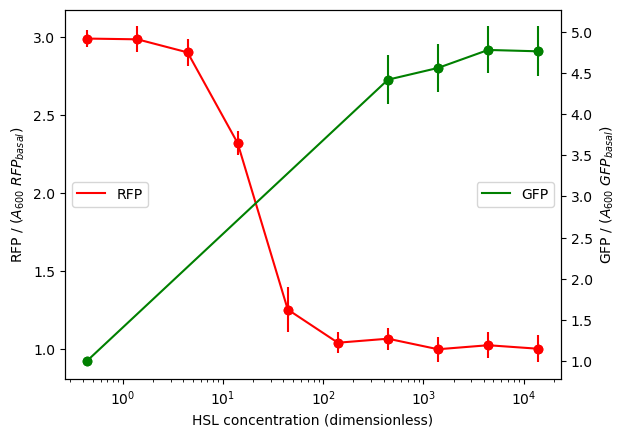

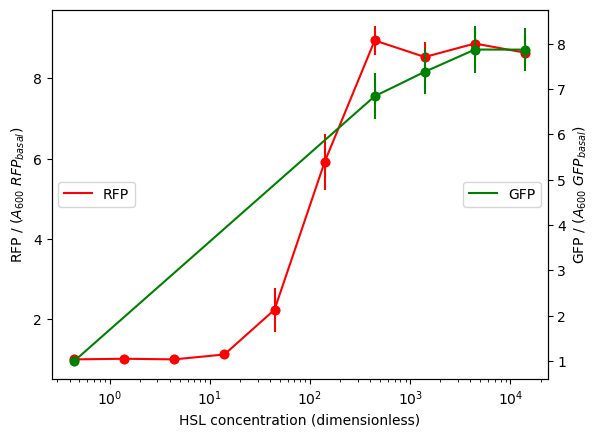

In [9]:
HSLtransform = 0.14*10**3
filename = 'Jure_subcircuit1_circuit14_doseResponseOC14_0.5ATC.pkl'
OC14_list1_red, gfpExp_list1, rfpExp_list1, semGreen1, semRed1 = load_dose_response(filename)
print(OC14_list1_red)
del gfpExp_list1[1:6]
del semGreen1[1:6]
OC14_list1_green = [OC14_list1_red[x] for x in [0,6,7,8,9]]
plotData_croppedGreen(OC14_list1_green, OC14_list1_red, rfpExp_list1, gfpExp_list1, semRed1, semGreen1)

filename = 'Jure_subcircuit3_circuit14_doseResponseOC14_0.5ATC.pkl'
OC14_list3_red, gfpExp_list3, rfpExp_list3, semGreen3, semRed3 = load_dose_response(filename)

del gfpExp_list3[1:6]
del semGreen3[1:6]
OC14_list3_green = [OC14_list3_red[x] for x in [0,6,7,8,9]]
plotData_croppedGreen(OC14_list3_green, OC14_list3_red, rfpExp_list3, gfpExp_list3, semRed3, semGreen3)


#### Subcircuit 1 fitting


In [10]:

nvd = 2
nfe = 5
nda=2
nce=3




def gfp1_steadystate(OC14, Vf,Kvd): 
    muv = 0.0225 ; kv =  0.0183 ;
    F1 = 1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))
    return F1


def rfp1_steadystate(OC14, Ve, Vf,Kvd,Kfe): 
    muv = 0.0225 ; kv =  0.0183 ;
    E1 = 1 + Ve*(1/(1+((1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd )))/(Kfe+1e-8))**nfe))
    
    return E1

OC14_continuous = np.logspace(-3,2, 100)*HSLtransform


def steadystate_subcircuit1(OC14, Ve, Vf, Kvd, Kfe):
  
  if len(OC14) == 15:
      gaps = [5,10]
  else:
     gaps = [int(len(OC14)/2)]*2
  F1 = gfp1_steadystate(OC14[:np.sum(gaps[:1])],  Vf,Kvd)
  E1 = rfp1_steadystate(OC14[np.sum(gaps[:1]):np.sum(gaps[:2])],Ve, Vf,Kvd,Kfe)
  FE = np.hstack([F1,E1])
  return FE


fluorescenceData = np.hstack([gfpExp_list1,rfpExp_list1])
OC14data_new = np.hstack([OC14_list1_green,OC14_list1_red])
OC14data_continuous= np.hstack([OC14_continuous,OC14_continuous])
semStacked= np.hstack([semGreen1,semRed1])

# popt, pcov = curve_fit(f=steadystate, xdata=OC14data_new, ydata=fluorescenceData ,sigma =semStacked)
popt_subcircuit1, pcov_subcircuit1 = curve_fit(f=steadystate_subcircuit1, xdata=OC14data_new, ydata=fluorescenceData,  p0 = [2,3.5,0.1,3],maxfev=10000000, bounds=(0,100))

# paramNames = ['Vc','Vd','Ve','Vf', 'Kvd','Kda', 'Kfe', 'Kce']
paramNames_subcircuit1 = ['Ve','Vf', 'Kvd','Kfe']
pfitDict = {}
for param in popt_subcircuit1:
    pfitDict[paramNames_subcircuit1[popt_subcircuit1.tolist().index(param)]] = param
pfitDict

{'Ve': 1.996884867725002,
 'Vf': 3.636473771393298,
 'Kvd': 18.945124558806153,
 'Kfe': 2.2605601253644036}

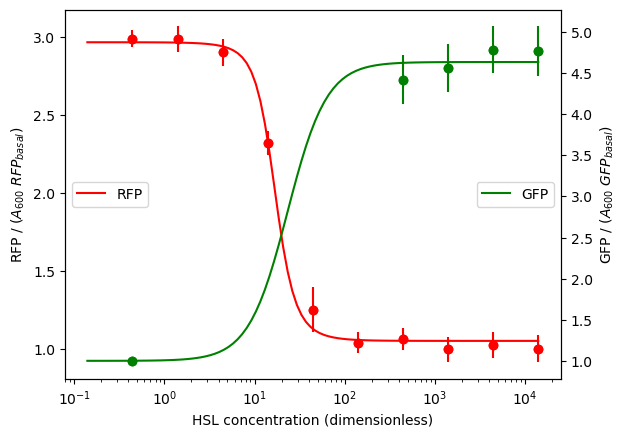

In [12]:
fluorescenceFit = steadystate_subcircuit1(OC14data_new, *popt_subcircuit1)
fluorescenceFit_continuous = steadystate_subcircuit1(OC14data_continuous,*popt_subcircuit1)
gfpFit1 = fluorescenceFit[:10]; rfpFit1 = fluorescenceFit[10:20]
gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]

plotFitvsData_croppedGreen(OC14_list1_green, OC14_list1_red,OC14_continuous, gfpExp_list1, rfpExp_list1, semGreen1, semRed1, gfpFit1_continuous,rfpFit1_continuous, save_figure=True, save_figure_name='bestFit_dose_response_subcircuit1.pdf')

gfpFit1_continuous_copy,rfpFit1_continuous_copy = gfpFit1_continuous,rfpFit1_continuous



### Subcircuit 3 fitting


In [25]:
Ve 

7.9465648854961835

In [5]:

nvd = 2
nfe = 5
nda=2
nce=3

Kvd = pfitDict['Kvd']
Ve = np.amax(rfpExp_list3) - 1

# def gfp3_steadystate(OC14,  Vd,Kvd): 
def gfp3_steadystate(OC14,  Vd): 
    muv = 0.0225 ; kv =  0.0183 ;
    D3 = 1 + Vd*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))

    return D3

def bfp3_steadystate(D,Vc,Kda):
    C3 = 1 + Vc*(1/(1+((D/(Kda+1e-8))**nda)))
    return C3


# def rfp3_steadystate(D,Vc, Kda,Kce): 
# def rfp3_steadystate(D,Vc,Ve, Kda,Kce): 
def rfp3_steadystate(D,Vc, Kda,Kce): 

    E3 = 1 + Ve*(1/(1+((bfp3_steadystate(D, Vc, Kda)/(Kce+1e-8))**nce)))
    return E3



OC14_continuous = np.logspace(-3,2, 100)*HSLtransform


# def steadystate_subcircuit3(OC14, Vc, Vd,Kvd, Kda, Kce):
# def steadystate_subcircuit3(OC14, Vc, Vd, Ve,Kvd, Kda, Kce):
# def steadystate_subcircuit3(OC14, Vc, Vd, Ve, Kda, Kce):
def steadystate_subcircuit3(OC14, Vc, Vd, Kda, Kce):
  if len(OC14) == 15:
      gaps = [5,10]
  else:
     gaps = [int(len(OC14)/2)]*2
#   D3 = gfp3_steadystate(OC14[:np.sum(gaps[:1])], Vd,Kvd)
  D3 = gfp3_steadystate(OC14[:np.sum(gaps[:1])], Vd)
  # E3 = rfp3_steadystate(OC14[np.sum(gaps[:1]):np.sum(gaps[:2])], Vc,Ve, Kda,Kce)
  E3 = rfp3_steadystate(OC14[np.sum(gaps[:1]):np.sum(gaps[:2])], Vc, Kda,Kce)
  DE = np.hstack([D3,E3])
  return DE


fluorescenceData = np.hstack([gfpExp_list3,rfpExp_list3])
OC14data_new = np.hstack([OC14_list3_green,OC14_list3_red])
OC14data_continuous= np.hstack([OC14_continuous,OC14_continuous])
semStacked= np.hstack([semGreen3,semRed3])

# popt, pcov = curve_fit(f=steadystate, xdata=OC14data_new, ydata=fluorescenceData ,sigma =semStacked)
popt_subcircuit3, pcov_subcircuit3 = curve_fit(f=steadystate_subcircuit3, xdata=OC14data_new, ydata=fluorescenceData, maxfev=10000, bounds=(0,100))

# paramNames = ['Vc','Vd','Ve','Vf', 'Kvd','Kda', 'Kfe', 'Kce']
# paramNames_subcircuit3 = ['Vc', 'Vd', 'Ve','Kvd', 'Kda', 'Kce']
paramNames_subcircuit3 = ['Vc', 'Vd',  'Kda', 'Kce']
# paramNames_subcircuit1 = ['Vc', 'Vd','Kvd', 'Kda', 'Kce']
# pfitDict3 = {}
for count, param in enumerate(popt_subcircuit3):
    pfitDict[paramNames_subcircuit3[count]] = param
    # pfitDict1[paramNames[popt.tolist().index(param)]] = param
pfitDict

{'Ve': 1.996884867725002,
 'Vf': 3.636473771393298,
 'Kvd': 18.945124558806153,
 'Kfe': 2.2605601253644036,
 'Vc': 9.954618355012913,
 'Vd': 6.49773511911512,
 'Kda': 67.92889962318986,
 'Kce': 3.472644502114762}

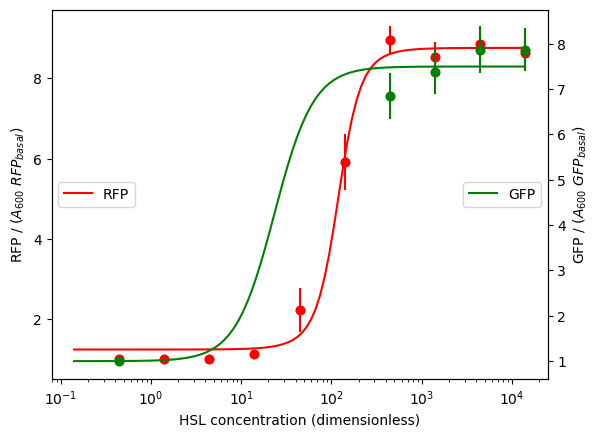

In [7]:
fluorescenceFit = steadystate_subcircuit3(OC14data_new, *popt_subcircuit3)
fluorescenceFit_continuous = steadystate_subcircuit3(OC14data_continuous,*popt_subcircuit3)
gfpFit3 = fluorescenceFit[:10]; rfpFit3 = fluorescenceFit[10:20]
gfpFit3_continuous = fluorescenceFit_continuous[:100]; rfpFit3_continuous = fluorescenceFit_continuous[100:200]

plotFitvsData_croppedGreen(OC14_list3_green, OC14_list3_red,OC14_continuous, gfpExp_list3, rfpExp_list3, semGreen3, semRed3, gfpFit3_continuous,rfpFit3_continuous,save_figure=True,save_figure_name='bestFit_dose_response_subcircuit3.pdf')

gfpFit3_continuous_copy,rfpFit3_continuous_copy = gfpFit3_continuous,rfpFit3_continuous



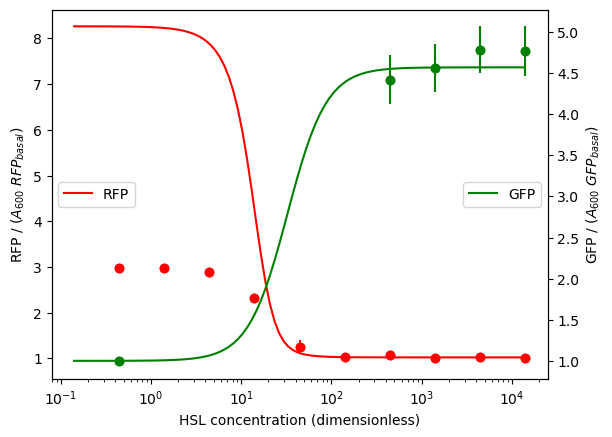

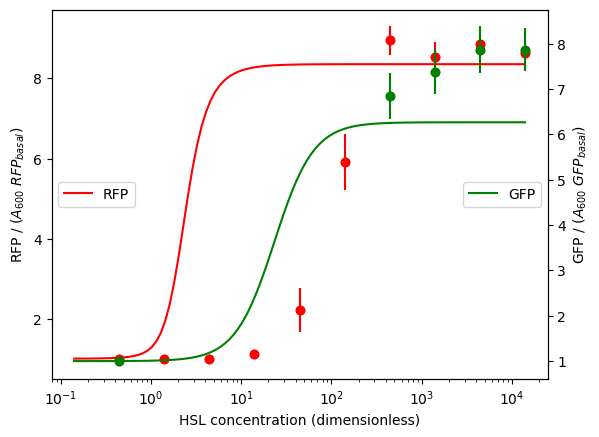

In [28]:
turingDict = {'Ve': 8.538026462365124,
 'Vf': 3.571758153811742,
 'Kvd': 26.388959901206217,
 'Kfe': 1.4165582004454278,
 'Vc': 16.95302523649266,
 'Vd': 5.268430929692057,
 'Kda': 0.7312899137021844,
 'Kce': 2.3167863396033366}


turing_popt_subcircuit1 = list(turingDict.values())[:4]
turing_popt_subcircuit3 = list(turingDict.values())[4:]



fluorescenceFit = steadystate_subcircuit1(OC14data_new, *turing_popt_subcircuit1)
fluorescenceFit_continuous = steadystate_subcircuit1(OC14data_continuous,*turing_popt_subcircuit1)
gfpFit1 = fluorescenceFit[:10]; rfpFit1 = fluorescenceFit[10:20]
gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]

plotFitvsData_croppedGreen(OC14_list1_green, OC14_list1_red,OC14_continuous, gfpExp_list1, rfpExp_list1, semGreen1, semRed1, gfpFit1_continuous,rfpFit1_continuous)

gfpFit1_continuous_copy,rfpFit1_continuous_copy = gfpFit1_continuous,rfpFit1_continuous




fluorescenceFit = steadystate_subcircuit3(OC14data_new, *turing_popt_subcircuit3)
fluorescenceFit_continuous = steadystate_subcircuit3(OC14data_continuous,*turing_popt_subcircuit3)
gfpFit3 = fluorescenceFit[:10]; rfpFit3 = fluorescenceFit[10:20]
gfpFit3_continuous = fluorescenceFit_continuous[:100]; rfpFit3_continuous = fluorescenceFit_continuous[100:200]

plotFitvsData_croppedGreen(OC14_list3_green, OC14_list3_red,OC14_continuous, gfpExp_list3, rfpExp_list3, semGreen3, semRed3, gfpFit3_continuous,rfpFit3_continuous)

gfpFit3_continuous_copy,rfpFit3_continuous_copy = gfpFit3_continuous,rfpFit3_continuous



### Distribution creation



In [29]:

#sample from the two subcircuit fits
sampled_parameters_subcircuit1 = np.random.multivariate_normal(popt_subcircuit1,pcov_subcircuit1*10, size=1000, check_valid='warn')#
sampled_parameters_subcircuit3 = np.random.multivariate_normal(popt_subcircuit3,pcov_subcircuit3*10, size=1000, check_valid='warn')#


#stack two arrays horizontally
sampled_parameters = np.hstack([sampled_parameters_subcircuit1,sampled_parameters_subcircuit3])

#filter parameters for negative values
filtered_parameters = [p for p in sampled_parameters if np.all(p>0)]



In [30]:



def steadystate_combined_subcircuits(OC14,Ve, Vf, Kvd, Kfe, Vc, Vd, Kda, Kce):

  F1 = gfp1_steadystate(OC14, Vf,Kvd)
  E1 = rfp1_steadystate(OC14,Ve,Vf,Kvd,Kfe)
  D3 = gfp3_steadystate(OC14, Vd)
  E3 = rfp3_steadystate(OC14,  Vc, Kda,Kce)
  stacked_fluorescence = [F1,E1, D3, E3]

  return stacked_fluorescence


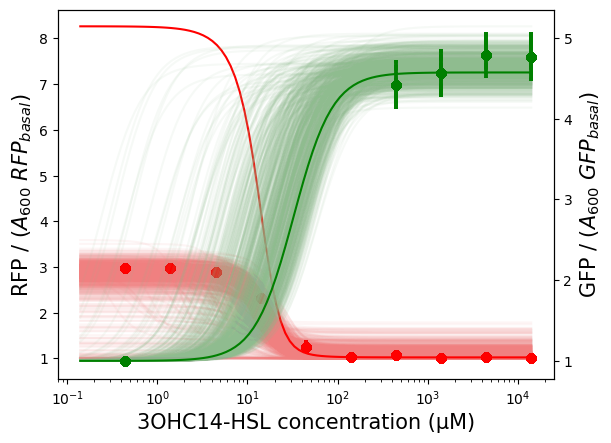

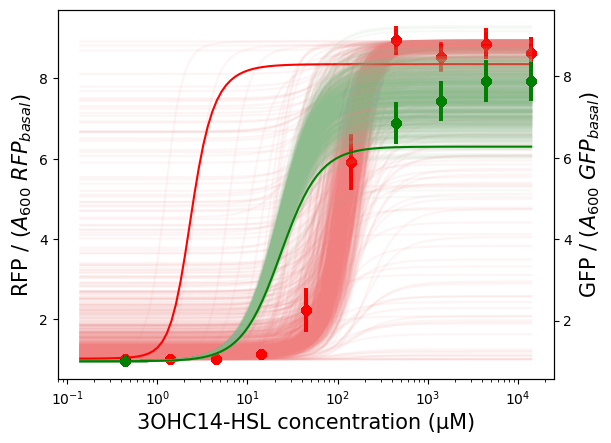

In [31]:

fig,ax = plt.subplots()
ax2=ax.twinx()
OC14_continuous = np.logspace(-3,2, 100)*HSLtransform
best_fit_p = np.hstack([popt_subcircuit1, popt_subcircuit3])
for p in filtered_parameters:
    fluorescenceFit = steadystate_combined_subcircuits(OC14_continuous, *p)
    fluorescenceFit_continuous = steadystate_combined_subcircuits(OC14_continuous, *p)
    fluorescenceSingleFit_continuous = steadystate_combined_subcircuits(OC14_continuous, *best_fit_p)

    
    ax2.plot(OC14_continuous, fluorescenceFit_continuous[0], c='darkseagreen', alpha=0.08)
    ax.plot(OC14_continuous, fluorescenceFit_continuous[1], c='lightcoral', alpha=0.08)
    ax2.scatter(OC14_list1_green,gfpExp_list1 , label='data', c='green')
    ax2.errorbar(OC14_list1_green,gfpExp_list1,yerr=semGreen1,c='green',fmt='o')
    ax.scatter(OC14_list1_red,rfpExp_list1 , label='data', c='red')
    ax.errorbar(OC14_list1_red,rfpExp_list1,yerr=semRed1,c='red',fmt='o')
    plt.xscale('log')


# ax.legend(loc='center left') #upper right
ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$', fontsize=15)
ax.set_xscale('log')
# ax2.legend(loc='center right') #upper left
ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$',fontsize=15)
ax.set_xscale('log')
ax.set_xlabel(f'3OHC14-HSL concentration (µM)',fontsize=15)
ax.plot(OC14_continuous, rfpFit1_continuous_copy, c='red', alpha=1)
ax2.plot(OC14_continuous, gfpFit1_continuous_copy, c='green', alpha=1)
plt.show()

gfpFit1_continuous_copy
fig,ax = plt.subplots()
ax2=ax.twinx()
for p in filtered_parameters:
    fluorescenceFit = steadystate_combined_subcircuits(OC14_continuous, *p)
    fluorescenceFit_continuous = steadystate_combined_subcircuits(OC14_continuous, *p)
    fluorescenceSingleFit_continuous = steadystate_combined_subcircuits(OC14_continuous, *best_fit_p)

    
    ax2.plot(OC14_continuous, fluorescenceFit_continuous[2], c='darkseagreen', alpha=0.08)
    ax.plot(OC14_continuous, fluorescenceFit_continuous[3], c='lightcoral', alpha=0.08)
    ax2.scatter(OC14_list1_green,gfpExp_list3 , label='data', c='green')
    ax2.errorbar(OC14_list1_green,gfpExp_list3,yerr=semGreen3,c='green',fmt='o')
    ax.scatter(OC14_list1_red,rfpExp_list3 , label='data', c='red')
    ax.errorbar(OC14_list1_red,rfpExp_list3,yerr=semRed3,c='red',fmt='o')
    plt.xscale('log')

# ax.legend(loc='center left') #upper right
ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$', fontsize=15)
ax.set_xscale('log')
# ax2.legend(loc='center right') #upper left
ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$', fontsize=15)
ax.set_xscale('log')
ax.set_xlabel(f'3OHC14-HSL concentration (µM)', fontsize=15)

ax.plot(OC14_continuous, rfpFit3_continuous_copy, c='red', alpha=1)
ax2.plot(OC14_continuous, gfpFit3_continuous_copy, c='green', alpha=1)
plt.show()

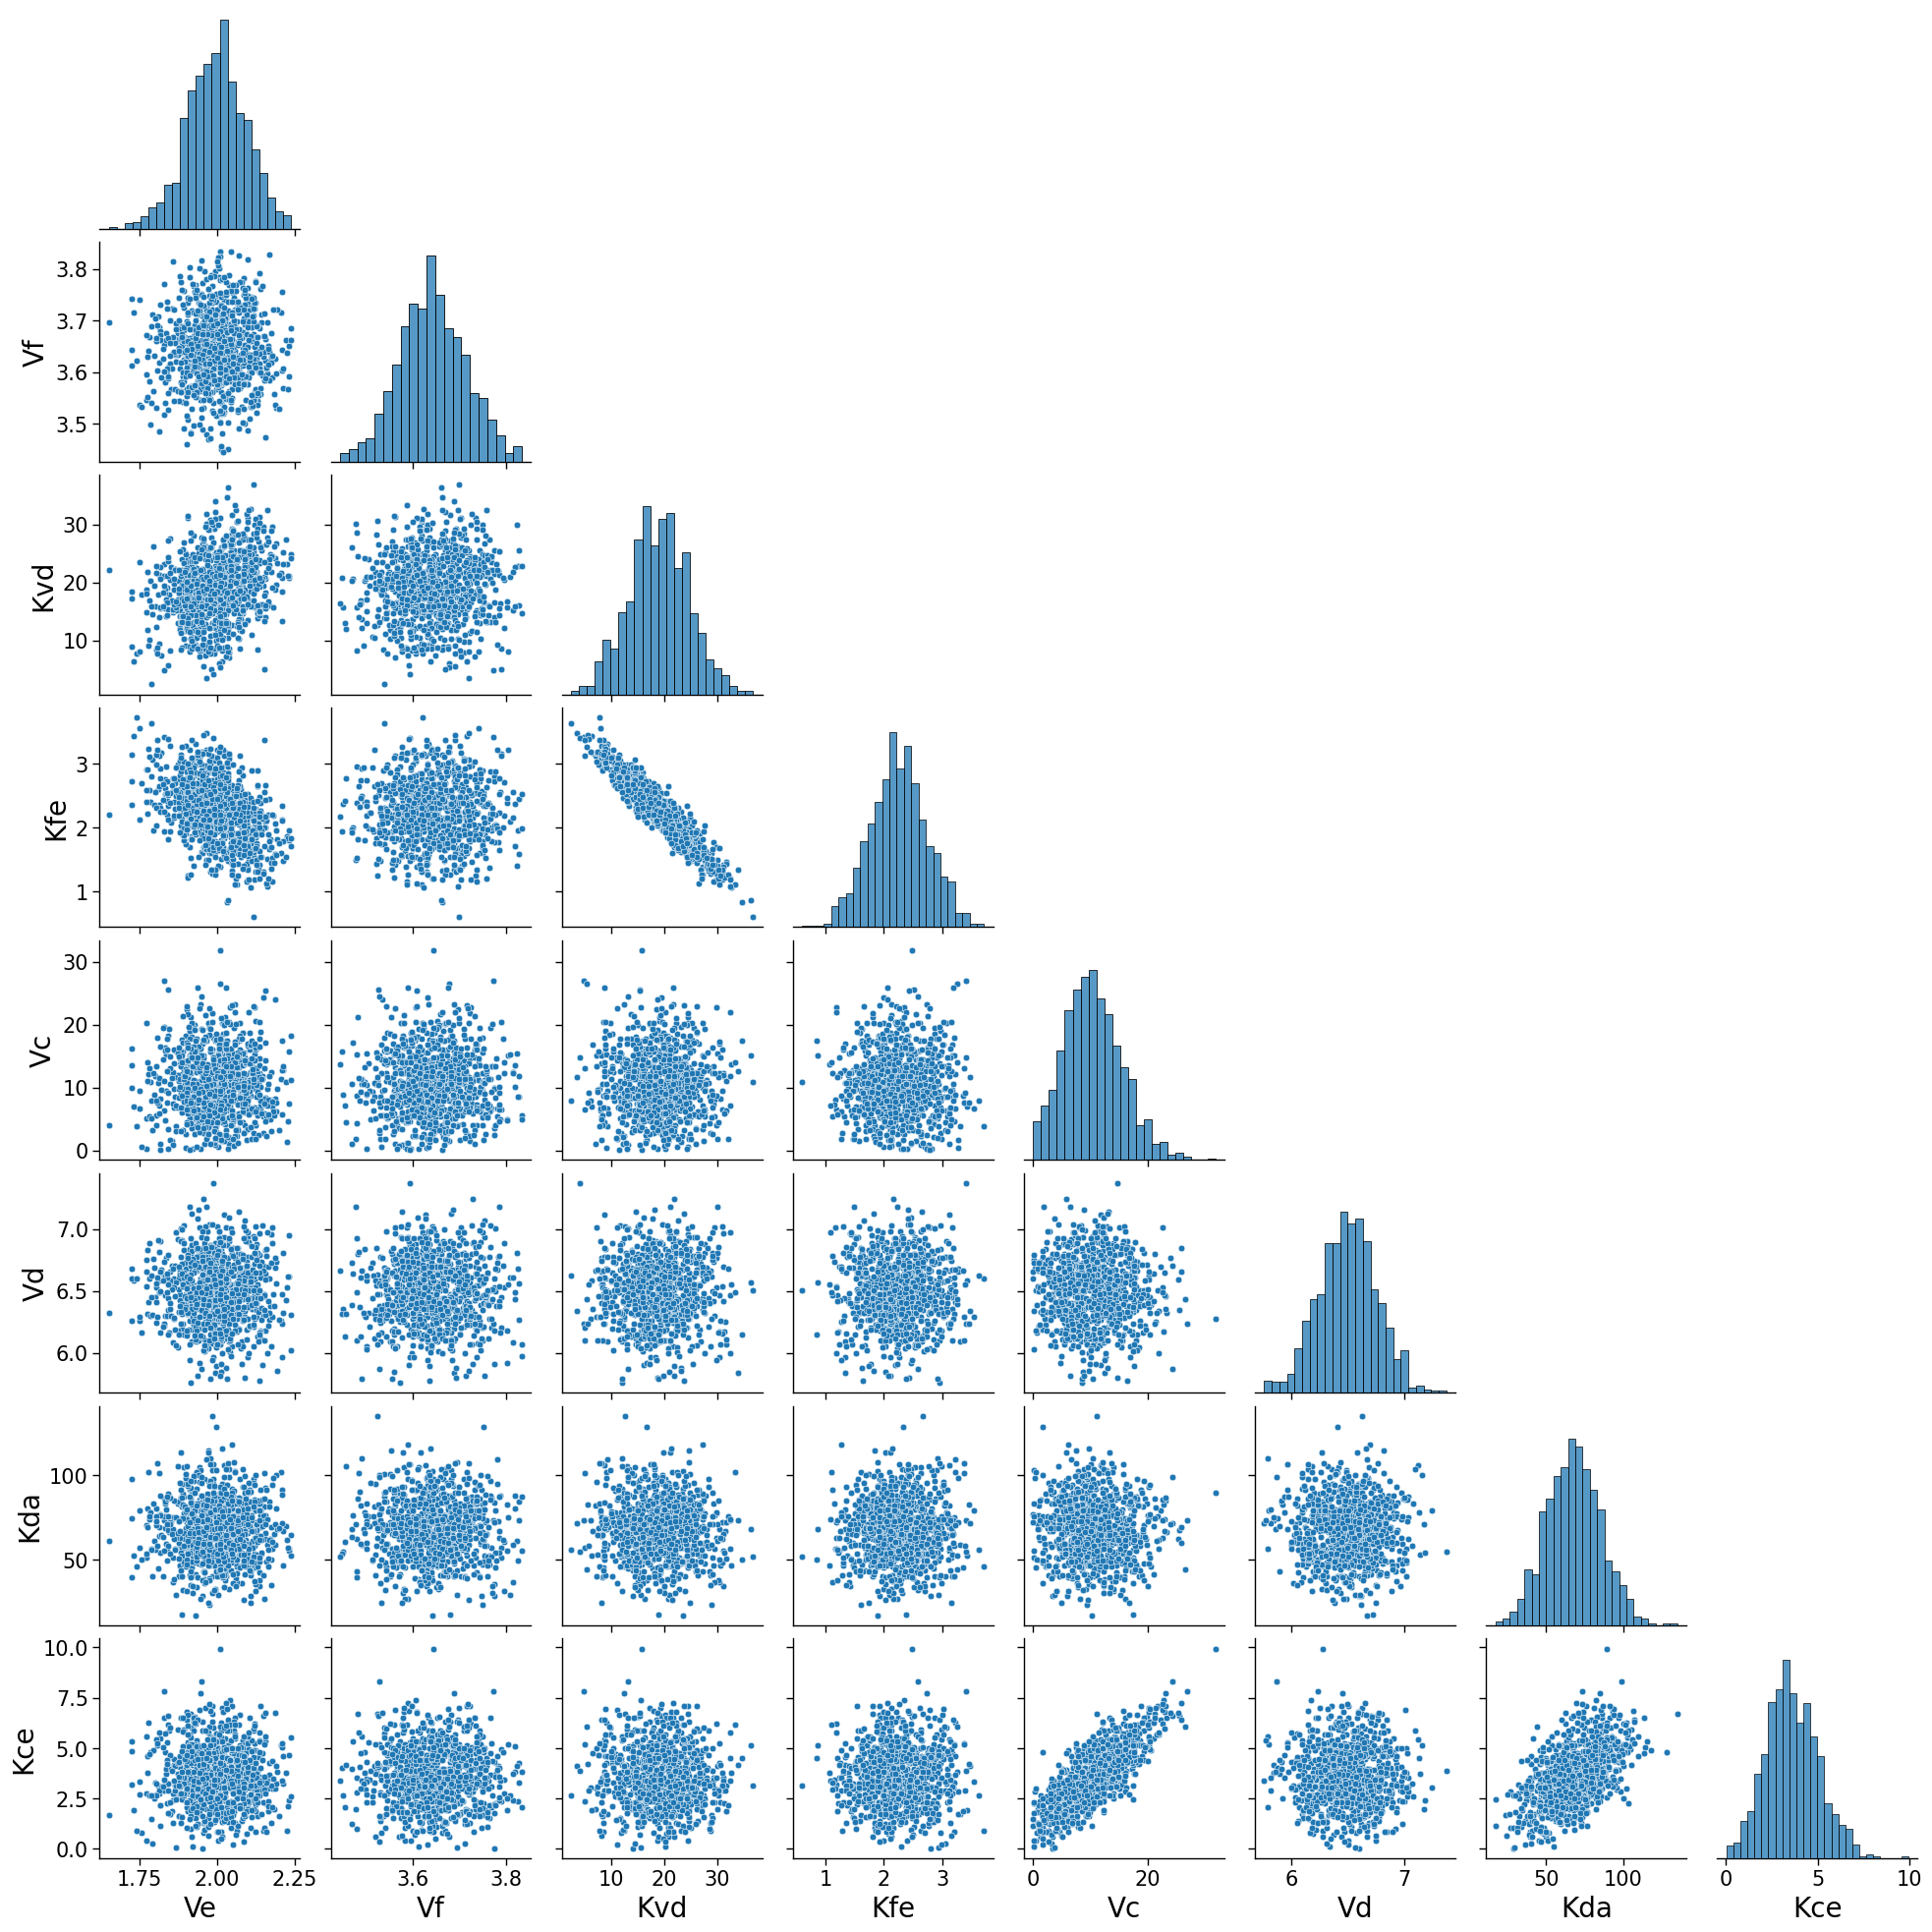

In [22]:
import pandas as pd
import seaborn as sns
sns.set_context("paper", rc={"axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15, "legend.fontsize":15, "axes.titlesize":20})
df = pd.DataFrame(filtered_parameters, columns= np.hstack([ paramNames_subcircuit1 , paramNames_subcircuit3]))
# df = pd.DataFrame(parameters_list, columns=paramNames)
# df['lossList'] = np.log(lossList)
sns.pairplot(df, corner=True)

# sns.pairplot(df, hue="lossList")
# sns.pairplot(df, hue="lossList", diag_kind='hist', diag_kws={'multiple': 'stack'},palette='rocket_r',corner=True)
# plt.show()

## Generate parameter set

In [13]:
# pfitDict['Ve'] = np.amax([rfpExp_list3, rfpExp_list1]) - 1
pfitDict['nvd'] = nvd
pfitDict['nfe'] = nfe
pfitDict['nda'] = nda
pfitDict['nce'] = nce
pfitDict

{'Ve': 1.996884867725002,
 'Vf': 3.636473771393298,
 'Kvd': 18.945124558806153,
 'Kfe': 2.2605601253644036,
 'Vc': 9.954618355012913,
 'Vd': 6.49773511911512,
 'Kda': 67.92889962318986,
 'Kce': 3.472644502114762,
 'nvd': 2,
 'nfe': 5,
 'nda': 2,
 'nce': 3}

100%|██████████| 2/2 [00:00<00:00, 224.39it/s]


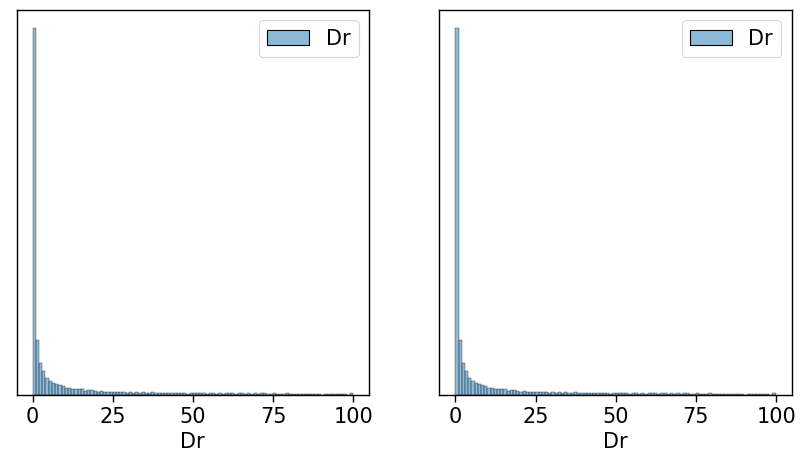

100%|██████████| 2/2 [00:00<00:00, 407.59it/s]


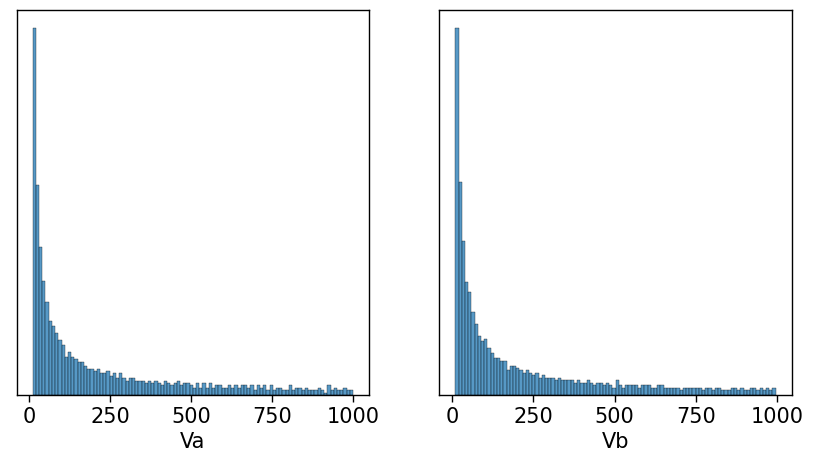

100%|██████████| 3/3 [00:00<00:00, 235.98it/s]


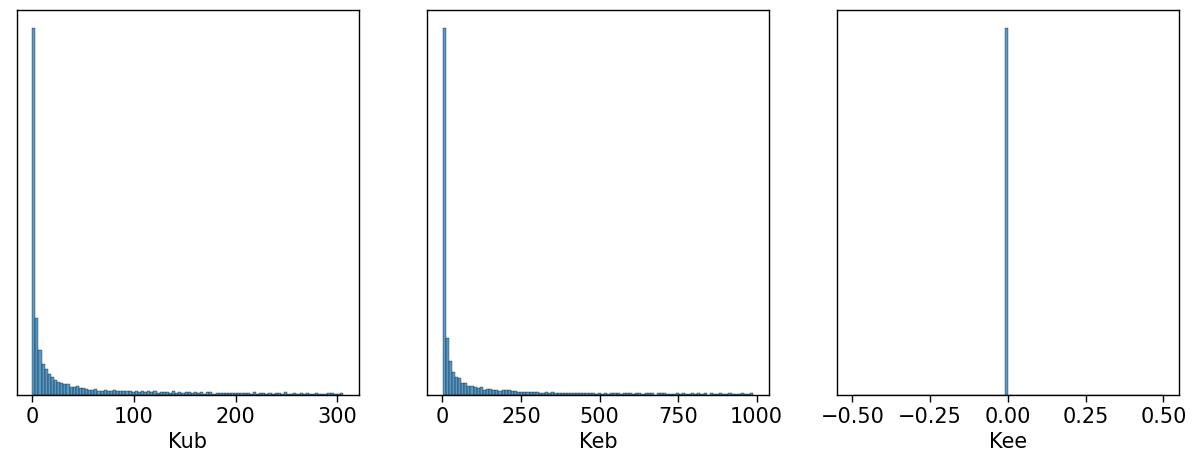

100%|██████████| 2/2 [00:00<00:00, 240.28it/s]


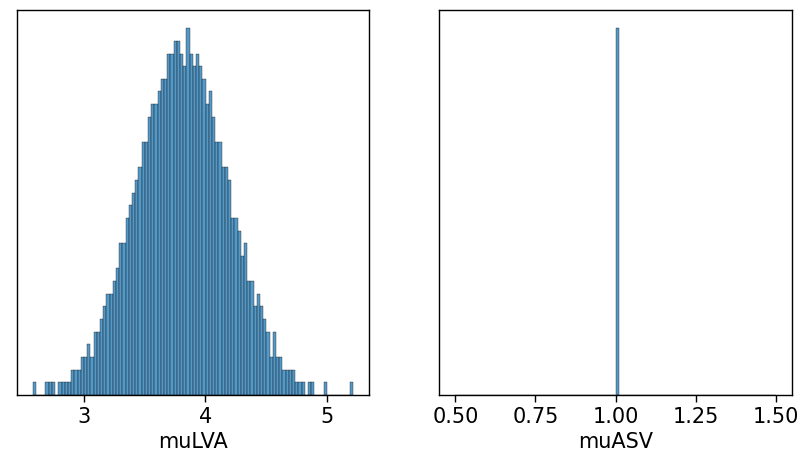

100%|██████████| 7/7 [00:00<00:00, 1221.61it/s]


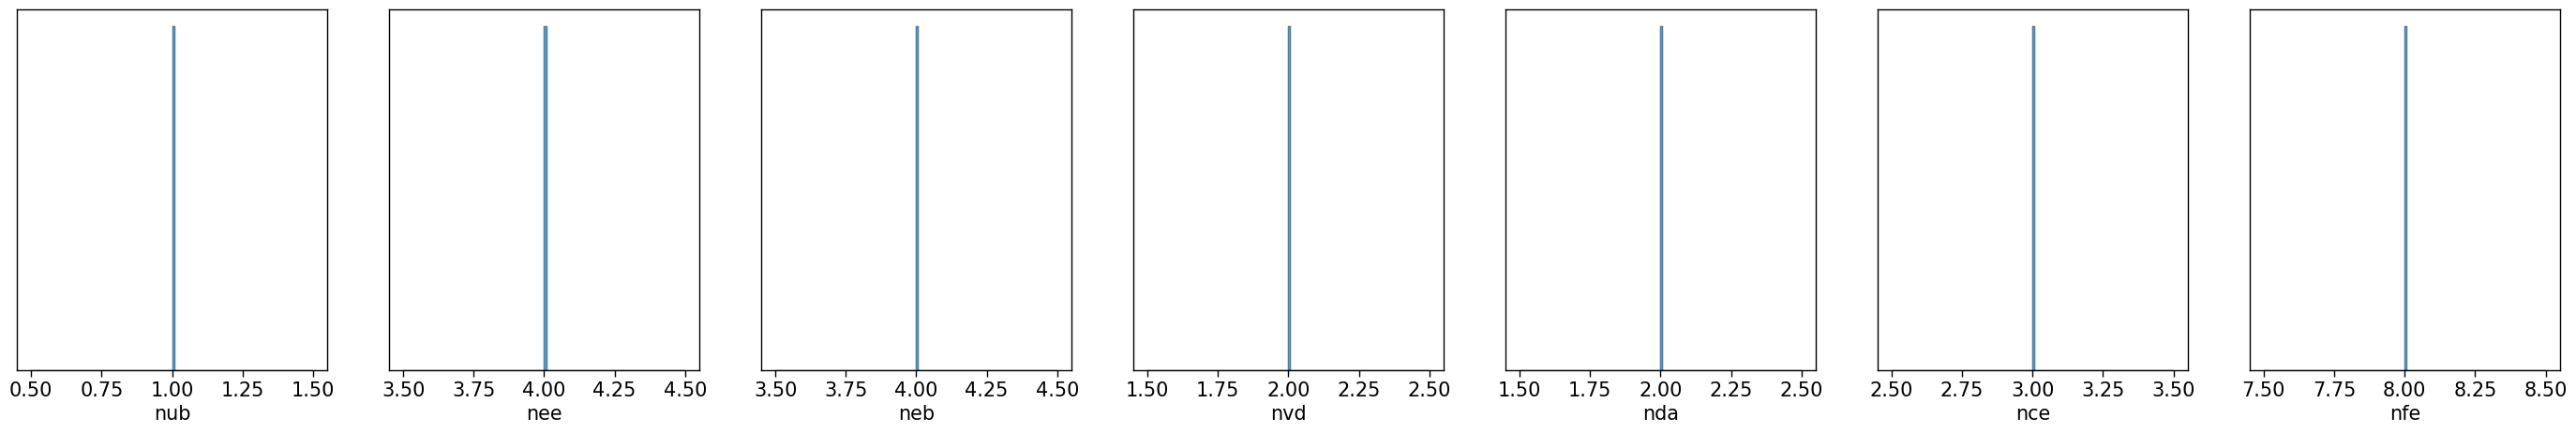

100%|██████████| 16/16 [00:00<00:00, 640.02it/s]

            Dr        Dr          Va          Vb         Kub         Keb  \
0     0.033220  0.072121   49.623870   21.689150    0.222103    0.288695   
1    47.471760  0.681413  310.199506  778.750417    6.351972  632.203660   
2     0.919135  0.265486   69.955156  175.631739   25.670274   66.704931   
3     8.316647  0.082679  161.996749  109.286203   37.782732  292.954590   
4    11.045726  0.227262  200.590235   19.406486    0.243323   61.443345   
..         ...       ...         ...         ...         ...         ...   
995   0.201837  0.024701  146.600746  523.942227    0.171611    0.231585   
996   1.976430  0.844402   46.303934  948.792180  291.360442    0.336080   
997   0.420002  7.536512  856.951347  214.054608    1.789711   66.145998   
998   2.061880  0.440169   46.934094   25.779813   12.276363    5.428165   
999   0.802224  0.246750   15.920716  113.674471  271.755453   44.927312   

       Kee     muLVA  muASV  nub  nee  neb  nvd  nda  nce  nfe  
0    0.001  4.006276  

In [18]:
#############
###paths#####
#############
import sys
import os




pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1]
sys.path.append(modellingpath + '/lib')
#############
from equations.parameterCreation_functions import *
#############
import numpy as np
import pandas as pd
import pickle as pkl
# %matplotlib inline

circuit_n=14
variant='fitted4'
#diffusion parameters


#maximum production parameters (V*)
minV = 10;maxV=1000;minb=0.1;maxb=1
Va = {'name':'Va','distribution':'loguniform', 'min':minV/maxb, 'max':maxV/minb}
Vb = {'name':'Vb','distribution':'loguniform', 'min':minV/maxb, 'max':maxV/minb}
# Ve = {'name':'Ve','distribution':'gaussian', 'mean':pfitDict['Ve'], 'noisetosignal':0.3}
V_parameters = [Va,Vb]



K1=0.0183; K2=0.0183
DUmin=0.1; DUmax=10; DVmin=0.1; DVmax=10
muU=0.0225; muV=0.0225
KdiffpromMin=0.1;KdiffpromMax=250
muLVA_estimate =1.143
muAAV_estimate =0.633
muASV_estimate=0.300 #this corresponds to mua

def Dr_(K1,K2,muU,muV,DU_,DV_):
    return (K2*DV_*muU)/(K1*DU_*muV)


def Kdiffstar(mudiff,Kdiffprom,kdiff):
    return mudiff*Kdiffprom/kdiff

def Kstar(mu,b,K):
    return mu/b*K

Dr = {'name':'Dr','distribution':'loguniform', 'min':Dr_(K1,K2,muU,muV,DUmax,DVmin), 'max':Dr_(K1,K2,muU,muV,DUmin,DVmax)}
D_parameters = [Dr]

# [] at half activation parameters (K)
minK=0.1;maxK=250

Keb = {'name':'Keb','distribution':'loguniform', 'min':Kstar(muLVA_estimate,maxb,minK), 'max':Kstar(muLVA_estimate,minb,maxK)}

Kee = {'name':'Kee','distribution':'fixed','value':0.001}

Kub = {'name':'Kub','distribution':'loguniform', 'min':Kdiffstar(muU,KdiffpromMin,K2), 'max':Kdiffstar(muU,KdiffpromMax,K2)}


K_parameters = [ Kub, Keb, Kee]



#protein degradation parameters (mu)
muASV = {'name':'muASV','distribution':'fixed', 'value':muASV_estimate/muASV_estimate}
muLVA = {'name':'muLVA','distribution': 'gaussian','mean':muLVA_estimate /muASV_estimate, 'noisetosignal':0.1}
mu_parameters = [muLVA,muASV]


#cooperativity parameters (n)
nvd = {'name':'nvd','distribution':'fixed', 'value':pfitDict['nvd']}
nfe = {'name':'nfe','distribution':'fixed', 'value': pfitDict['nfe']} #ideally hihger but we keep lower to ensure numerics work
nda = {'name':'nda','distribution':'fixed', 'value':pfitDict['nda']}
nce = {'name':'nce','distribution':'fixed', 'value':pfitDict['nce']}
nub = {'name':'nub','distribution':'fixed', 'value':1}
nee = {'name':'nee','distribution':'fixed', 'value':4}
neb = {'name':'neb','distribution':'fixed', 'value':4}
nfe = {'name':'nfe','distribution':'fixed', 'value':8}
n_parameters = [nub,nee,neb,nvd,nda,nce,nfe]


plotDistributions=True
if plotDistributions == True:
    D_parameters = [Dr, Dr]
    nsamples=1000
    parameterTypeList = [ D_parameters  , V_parameters , K_parameters , mu_parameters , n_parameters]

    for parameterType in parameterTypeList:
        stackedDistributions = preLhs(parameterType)
        lhsDist = lhs(stackedDistributions,nsamples)
        lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterType])
        plotDist(parameterType,lhsDist_df)

createParams=True
if createParams == True:
    nsamples=1000
    # nsamples=int(sys.argv[1])
    # nsamples=14
    parameterDictList = D_parameters  + V_parameters + K_parameters + mu_parameters + n_parameters
    # parameterDictList = [DU, DV, bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF, Kbd, Kab, Kda, Kfe, Kee, Keb, Kce, KaTc, Kiptg, muLVA, muAAV, muASV, muUb, muVb, muaTc, muU, muV, nbd, nab, nda, nfe, nee, neb, nce, naTc, niptg, k1, k2, iptg]
    stackedDistributions = preLhs(parameterDictList)
    lhsDist = lhs(stackedDistributions,nsamples)
    lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
    # plotDist(parameterDictList,lhsDist_df)
    # pkl.dump(lhsDist_df, open(modellingpath + '/3954/paper/input/fitted_parameterfiles/df_circuit%r_variant%s_%rparametersets.pkl'%(circuit_n,variant,nsamples), 'wb'))

    print(lhsDist_df)


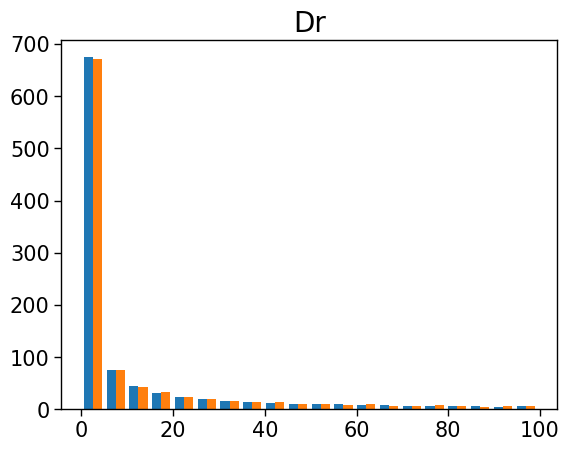

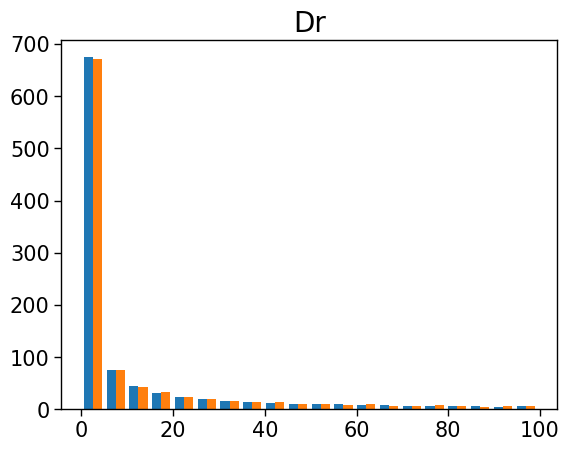

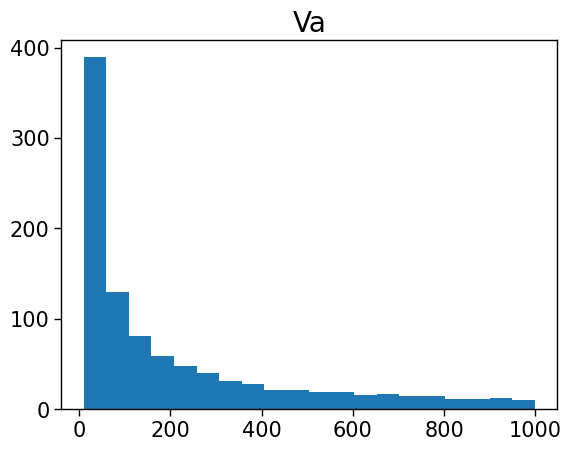

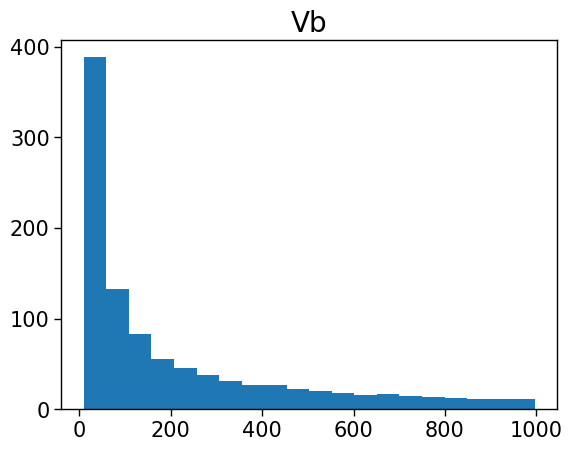

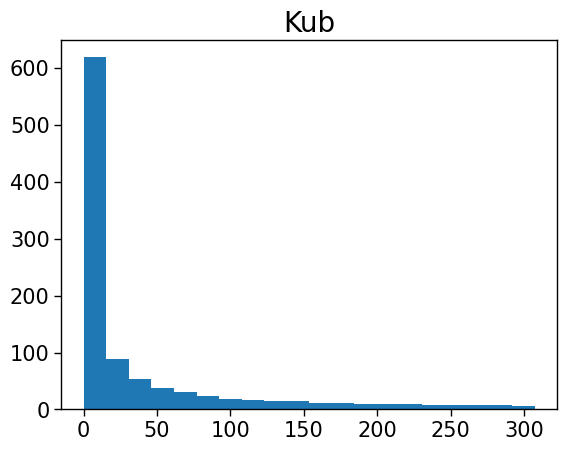

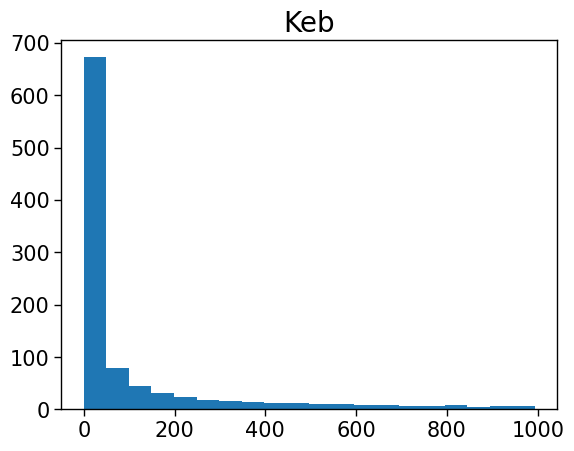

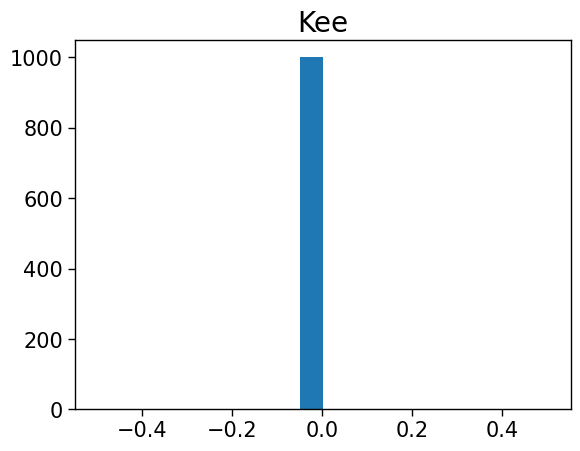

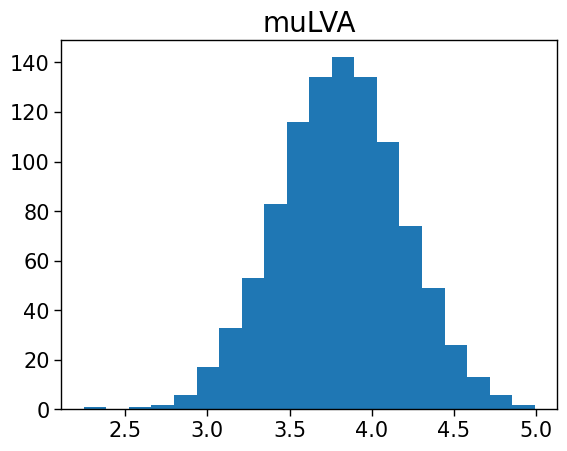

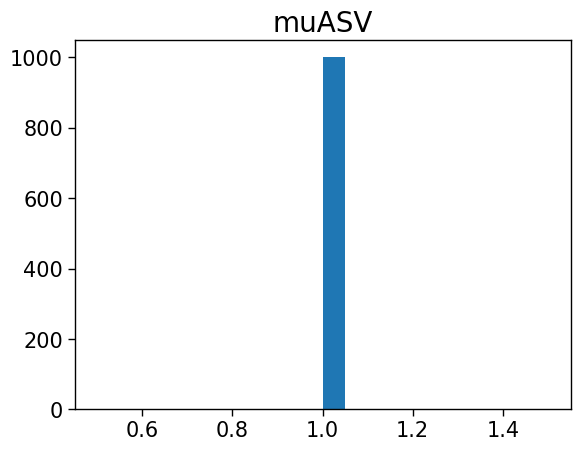

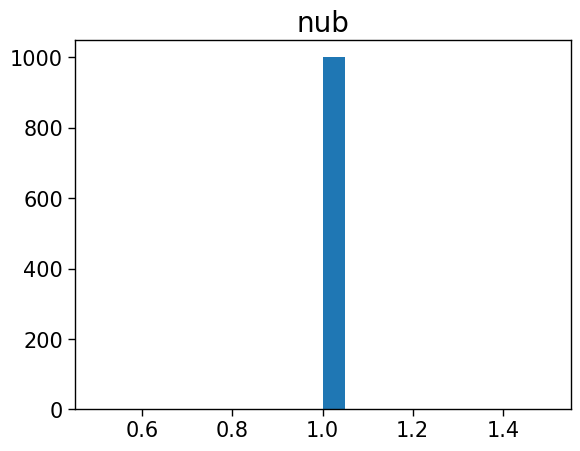

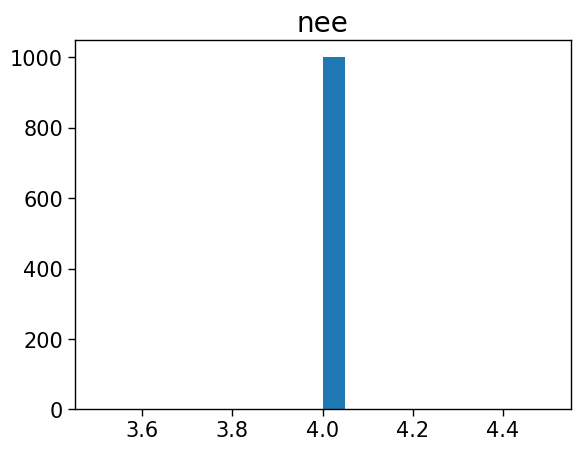

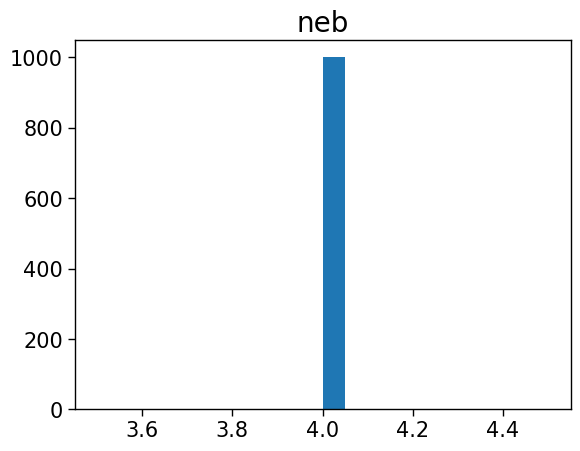

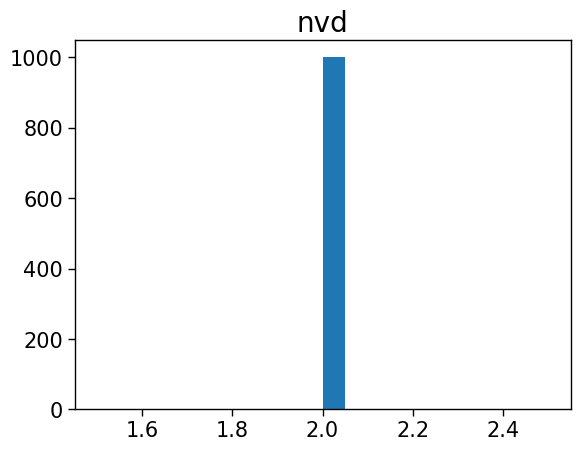

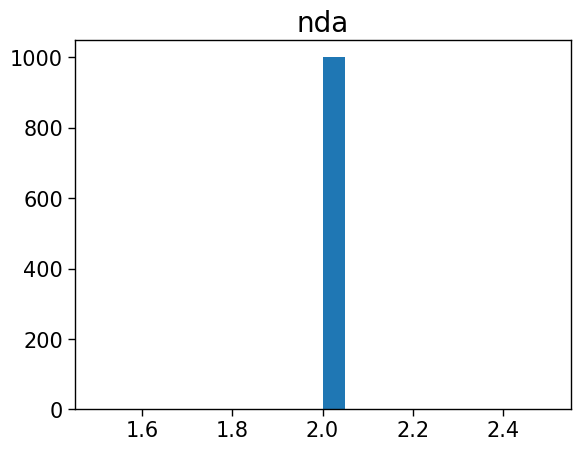

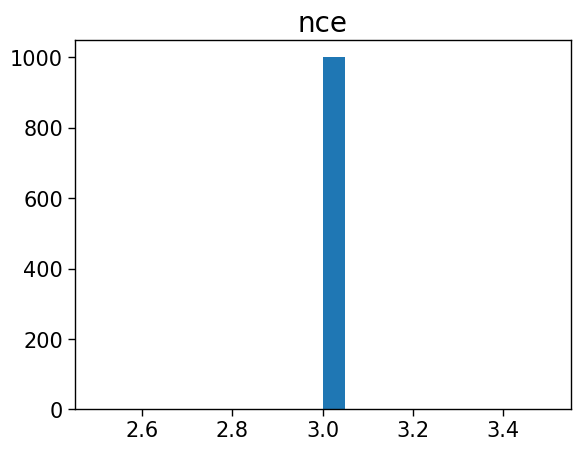

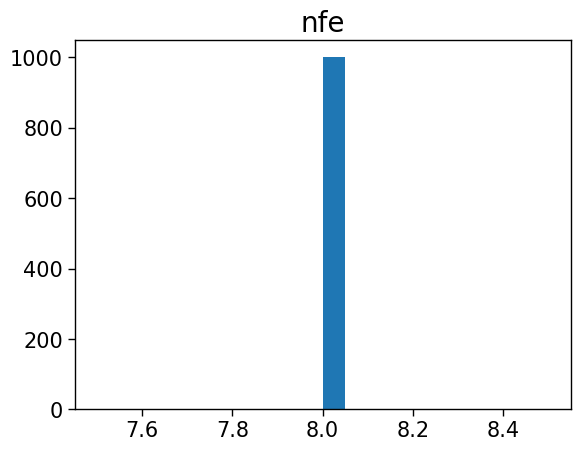

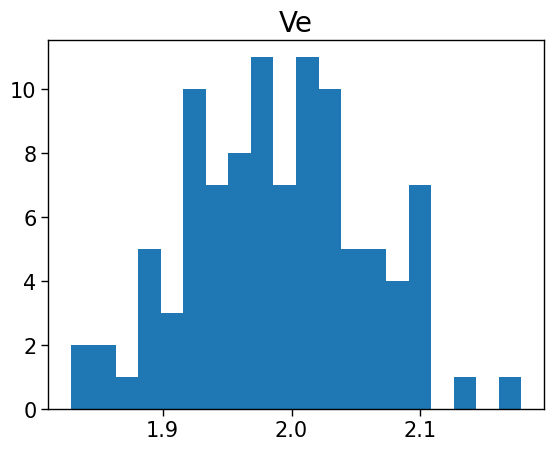

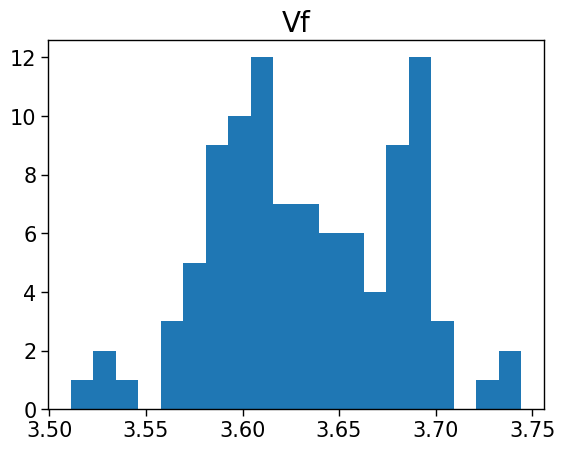

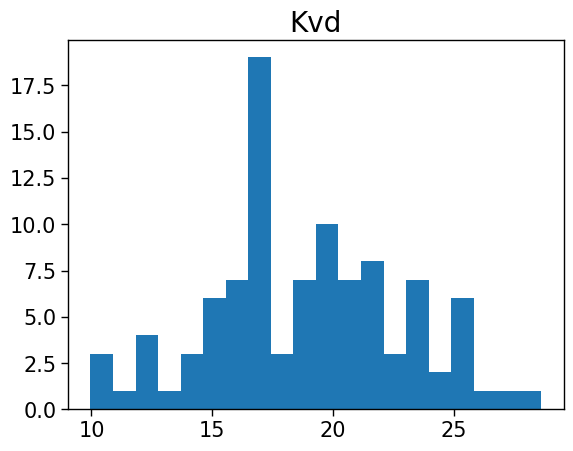

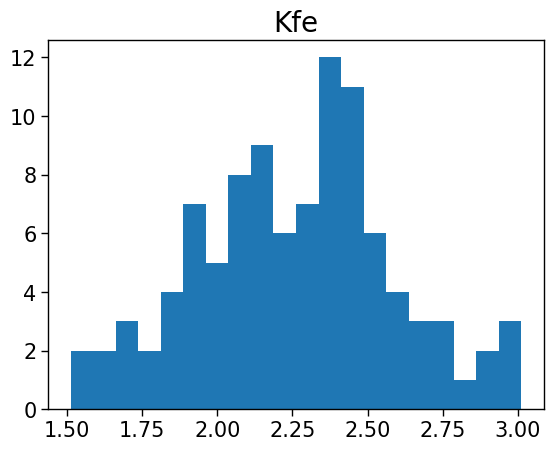

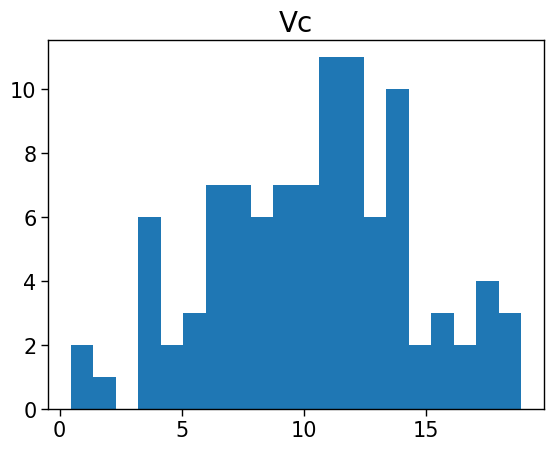

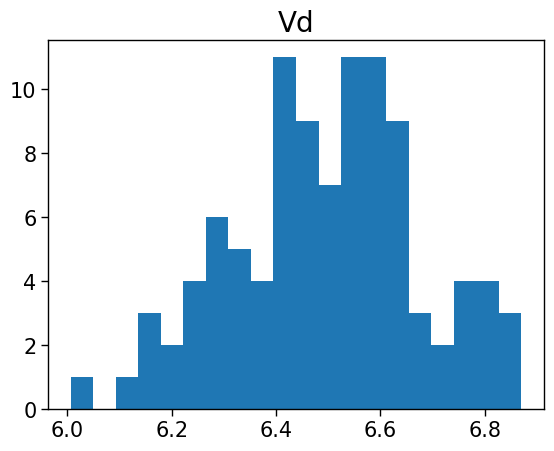

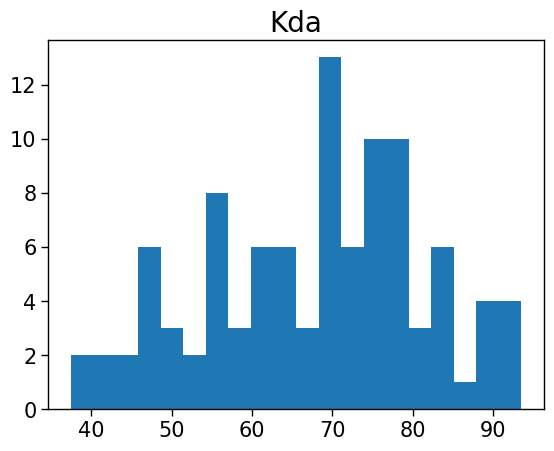

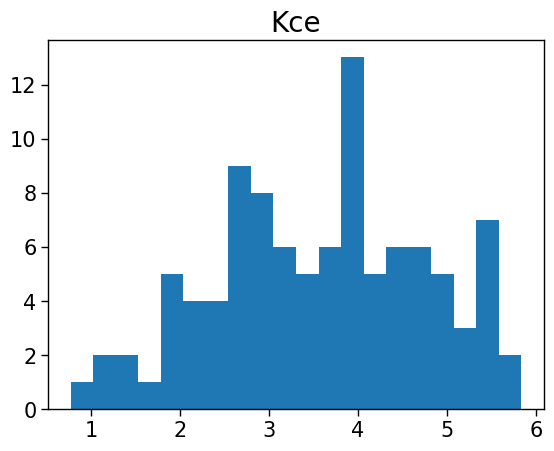

In [19]:
lhsDist_df
lhsDistFit_df=pd.concat([lhsDist_df, df], axis=1)

lhsDistFit_df

for column in lhsDistFit_df.columns:
    plt.hist(lhsDistFit_df[column],bins=20)
    plt.title(column)
    plt.show()
    

In [21]:
lhsDistFit_df = lhsDistFit_df.dropna()

In [22]:
lhsDistFit_df

,Dr,Dr,Va,Vb,Kub,Keb,Kee,muLVA,muASV,nub,...,nce,nfe,Ve,Vf,Kvd,Kfe,Vc,Vd,Kda,Kce
0,0.033220,0.072121,49.623870,21.689150,0.222103,0.288695,0.001,4.006276,1.0,1.0,...,3.0,8.0,2.099150,3.675557,22.663305,1.903889,7.092347,6.567008,66.096613,2.941178
1,47.471760,0.681413,310.199506,778.750417,6.351972,632.203660,0.001,3.034785,1.0,1.0,...,3.0,8.0,2.036588,3.660324,17.244140,2.393063,17.511106,6.721240,69.348303,5.463481
2,0.919135,0.265486,69.955156,175.631739,25.670274,66.704931,0.001,4.267307,1.0,1.0,...,3.0,8.0,2.081508,3.598540,24.704619,1.622636,12.191273,6.506493,68.723891,3.794182
3,8.316647,0.082679,161.996749,109.286203,37.782732,292.954590,0.001,4.311057,1.0,1.0,...,3.0,8.0,2.002174,3.613825,21.294231,2.127603,12.332188,6.339953,85.069046,5.099263
4,11.045726,0.227262,200.590235,19.406486,0.243323,61.443345,0.001,4.244762,1.0,1.0,...,3.0,8.0,1.974405,3.583254,18.932677,2.256476,10.400844,6.620308,55.014330,2.834140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,77.538592,27.694380,347.315451,514.205312,0.152057,617.033670,0.001,3.549268,1.0,1.0,...,3.0,8.0,2.038668,3.575311,16.657685,2.438398,14.019291,6.478829,58.721603,3.806235
96,0.088765,0.079791,423.216469,272.856611,65.892993,0.201922,0.001,4.026668,1.0,1.0,...,3.0,8.0,2.045998,3.688285,14.966738,2.562569,14.175509,6.399493,46.937419,3.326359
97,13.847085,0.268081,68.439213,14.932963,14.946303,36.931148,0.001,4.194906,1.0,1.0,...,3.0,8.0,1.972844,3.623188,24.325060,1.861522,11.236961,6.572753,69.839628,3.921619
98,0.103594,3.085669,16.956387,883.574813,3.087451,121.144067,0.001,4.215562,1.0,1.0,...,3.0,8.0,1.999443,3.705534,17.126897,2.408200,7.421854,6.639616,62.640822,2.577549


In [15]:

Km_list = ['Kda', 'Kub', 'Keb', 'Kvd', 'Kfe',  'Kce' ]
KtoV = {'Kda': 'Vd', 'Kub': 'Va', 'Keb': 'Ve', 'Kvd': 'Vb', 'Kfe': 'Vf','Kce': 'Vc' }

def checkBalance(par_dict):
    balanceDict = {}
    for Km in Km_list:
        # print(Km)
        Vx =par_dict[KtoV[Km]]
        Kxy = par_dict[Km]
        if Kxy >= 1 and Kxy <= Vx:
            balanceDict[Km] = 'Balanced'

        elif Kxy > 0.1 and Kxy < Vx*10:
            balanceDict[Km] ='Semi balanced'
        elif Kxy <= 0.1 or Kxy >= Vx*10:
            balanceDict[Km] ='Not balanced'
        else:
            print('ERROR!!!!!!!!!')

    if 'Not balanced' in balanceDict.values():
        return 'Not balanced'
    elif 'Semi balanced'  in balanceDict.values():
        print('semibalanced')
        return 'Semi balanced'
    elif all(x == 'Balanced' for x in balanceDict.values()):
        print('Balanced')
        return 'Balanced'
    

createBalancedParams=True
if createBalancedParams == True:
    nsamples=10
    # parameterDictList = D_parameters  + V_parameters + K_parameters + mu_parameters + n_parameters
    # stackedDistributions = preLhs(parameterDictList)
    balancedDf = pd.DataFrame()
    semiBalancedDf = pd.DataFrame()
    notBalancedDf = pd.DataFrame()
# while len(balancedDf)<nsamples:
    # lhsDist = lhs(stackedDistributions,nsamples, seed = seed, tqdm_disable = True)
    # lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
    #check balance

    balanceList = []    
    for parID in lhsDistFit_df.index:
        par_dict = lhsDistFit_df.loc[parID].to_dict()
        balanceList.append(checkBalance(par_dict))
    lhsDistFit_df['balance'] = balanceList
    
    #separate 3df
    balancedDfPre = lhsDistFit_df[lhsDistFit_df['balance']=='Balanced']
    semiBalancedDfPre = lhsDistFit_df[lhsDistFit_df['balance']=='Semi balanced']
    notBalancedDfPre = lhsDistFit_df[lhsDistFit_df['balance']=='Not balanced']
    
    #concat to df
    if len(balancedDf)<nsamples:
        balancedDf = pd.concat([balancedDf, balancedDfPre], ignore_index=True)
    if len(semiBalancedDf)<nsamples:
        semiBalancedDf = pd.concat([semiBalancedDf, semiBalancedDfPre], ignore_index=True)
    if len(notBalancedDf)<nsamples:
        notBalancedDf = pd.concat([notBalancedDf, notBalancedDfPre], ignore_index=True)

    lhsDistFit_df_balancesemibalance = lhsDistFit_df[lhsDistFit_df['balance']!='Not balanced']
        # pkl.dump(balancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_balanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(semiBalancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_semiBalanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(notBalancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_notBalanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(lhsDist_df, open(modellingpath + '/3954/paper/input/lhs_parameterfiles/df_circuit%r_variant%s_%rparametersets.pkl'%(circuit_n,variant,nsamples), 'wb'))


len(balancedDf), len(semiBalancedDf), len(notBalancedDf), len(lhsDistFit_df_balancesemibalance)

semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced
semibalanced

(0, 122, 60, 122)